In [66]:
%reset -f

# from pandasgui import show

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import *


%load_ext autoreload
%autoreload 2

# Load data
data = pd.read_csv('Data/non_nan_data.csv')
data = data.drop(['sun_mean', 'wind_mean', 'temp_mean', 'DK1_spot'], axis=1)

cols_to_lag = [col for col in data.columns if col.startswith('sun_') or col.startswith('temp_') or col.startswith('wind_')]
data[cols_to_lag] = data[cols_to_lag].shift(24)

lags_list = [24, 48, 72, 96, 120, 144, 168]

# Create columns with DK1_spot 24 hours lagged
for i in lags_list:
    data[f'DK2_spot_lag_{i}'] = data['DK2_spot'].shift(i)

data = data.dropna()

# Split data
data_train = data[(data['DATE'] >= '2014-01-01') & (data['DATE'] < '2023-01-01')].drop(['DATE'], axis=1).to_numpy()
data_test = data[data['DATE'] >= '2023-01-01'].drop(['DATE'], axis=1).to_numpy()

# To only use weather data one hour before the price, we lag weather data one hour
y_train = data_train[:, 0].reshape(-1, 1)
y_test = data_test[:, 0].reshape(-1, 1)

weather_train = data_train[:, 1:-len(lags_list)]
weather_test = data_test[:, 1:-len(lags_list)]

lags_train = data_train[:, -len(lags_list):]
lags_test = data_test[:, -len(lags_list):]

hour_dummies_train = sdummy(len(data_train), 24)
hour_dummies_test = sdummy(len(data_test), 24)

all_train = np.concatenate((weather_train, hour_dummies_train), axis=1)
all_test = np.concatenate((weather_test, hour_dummies_test), axis=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\peter\AppData\Local\Temp\ipykernel_10532\3491157243.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'DK2_spot_lag_{i}'] = data['DK2_spot'].shift(i)
C:\Users\peter\AppData\Local\Temp\ipykernel_10532\3491157243.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'DK2_spot_lag_{i}'] = data['DK2_spot'].shift(i)
C:\Users\peter\AppData\Local\Temp\ipykernel_10532\3491157243.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

## Baseline

SMAPE baseline out of sample prediction: 59.76360249598709


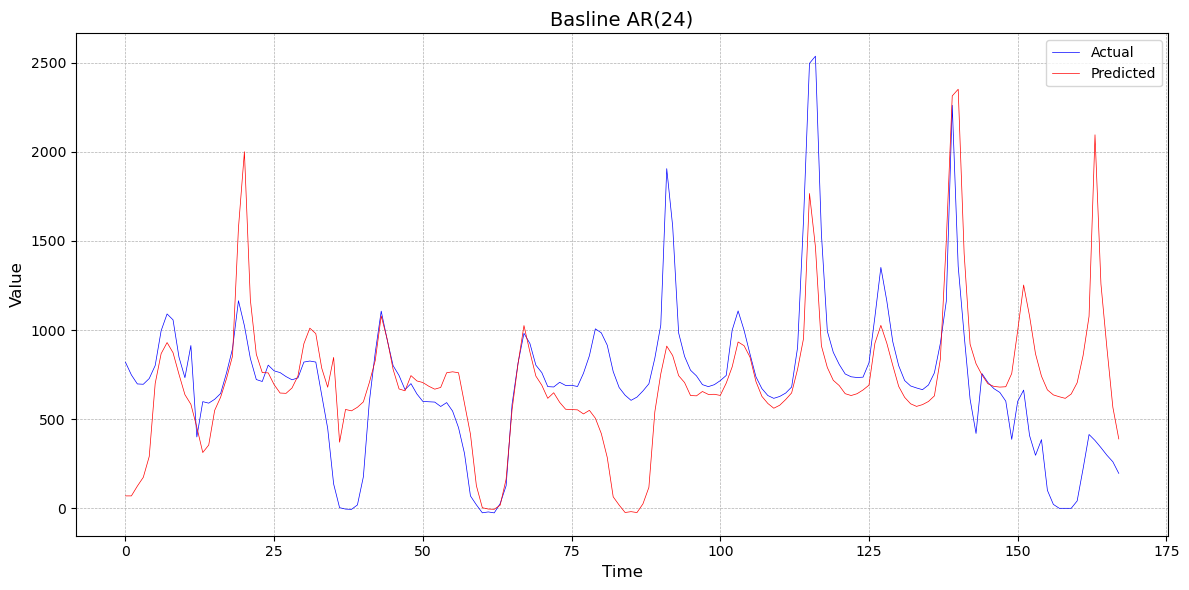

In [75]:
p = 0

con = 0
tr = 0
exog = lags_train[:, 0].reshape(-1, 1)
# exog = weather_train
# exog = hour_dummies_train
# exog = all_train

Beta, SEbeta, _, Pvalue, tratioBeta, res_baseline, _, _, aiccrit, hqccrit, siccrit = VARlsExog(y_train, p, con, tr, exog)


y_pred = lags_test[:, 0].reshape(-1, 1) @ Beta

smape_baseline = smape(y_test[p::], y_pred[p::])

print(f'SMAPE baseline out of sample prediction: {smape_baseline}')

plot_actual_vs_predicted(y_test, y_pred, "Basline AR(24)")

In [72]:
y_pred

array([[ 42.36152573],
       [  3.45867533],
       [-31.22834233],
       ...,
       [979.52782078],
       [693.53875063],
       [585.20710972]])

## Baseline with 24 lags

SMAPE baseline out of sample prediction: 53.210159654923416


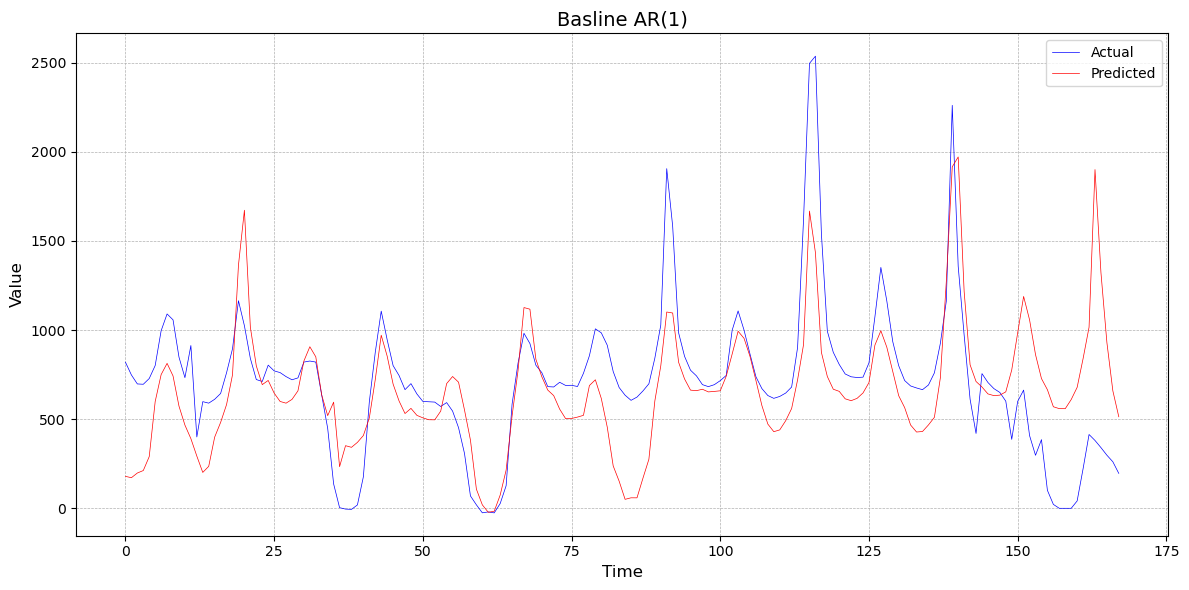

In [68]:
p = 0

con = 0
tr = 0
exog = lags_train
# exog = weather_train
# exog = hour_dummies_train
# exog = all_train

Beta, SEbeta, _, Pvalue, tratioBeta, res_baseline, _, _, aiccrit, hqccrit, siccrit = VARlsExog(y_train, p, con, tr, exog)


y_pred = lags_test @ Beta

smape_baseline = smape(y_test[p::], y_pred[p::])

print(f'SMAPE baseline out of sample prediction: {smape_baseline}')

plot_actual_vs_predicted(y_test, y_pred, "Basline AR(1)")

## Extended baseline with weather data

SMAPE baseline out of sample prediction: 52.78274921111167


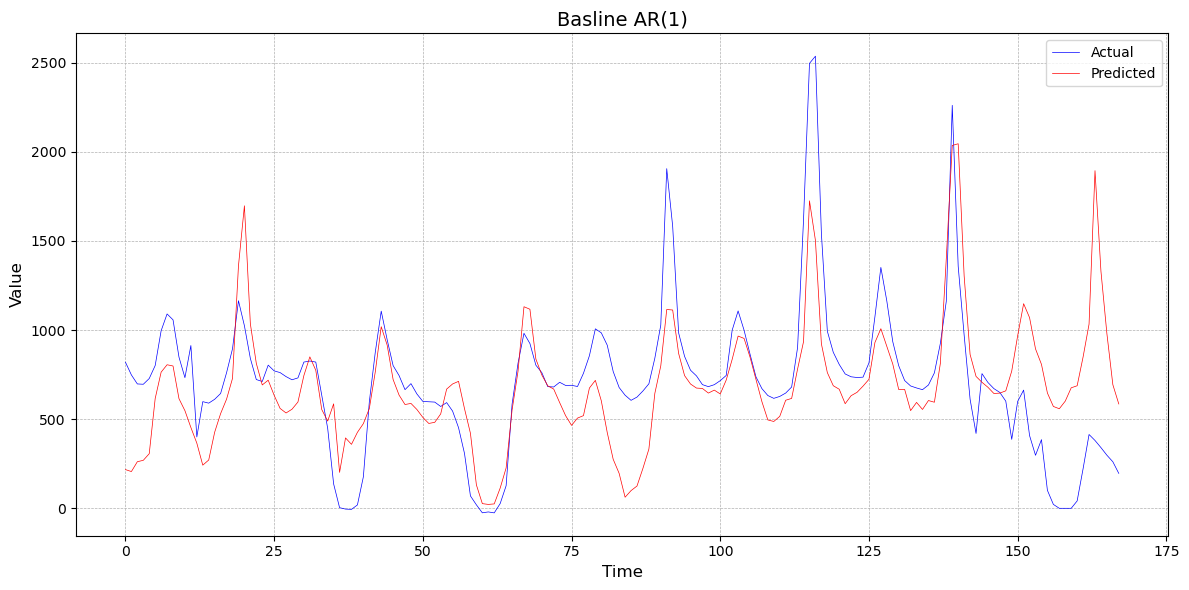

In [ ]:
p = 0

con = 0
tr = 0
exog = np.column_stack((lags_train, weather_train, hour_dummies_train))
# exog = hour_dummies_train
# exog = all_train



Beta, SEbeta, _, Pvalue, tratioBeta, res_baseline, _, _, aiccrit, hqccrit, siccrit = VARlsExog(y_train, p, con, tr, exog)


exog_test = np.column_stack((lags_test, weather_test, hour_dummies_test))

y_pred = exog_test @ Beta

smape_baseline = smape(y_test[p::], y_pred[p::])

print(f'SMAPE baseline out of sample prediction: {smape_baseline}')

plot_actual_vs_predicted(y_test, y_pred, "Basline AR(24)")